In [1]:
import numpy as np
import pandas as pd

Будем использовать датасет по заполнености помещения людьми. Благо, навзвания признаков весьма информативны.

In [2]:
df = pd.read_table('datatraining.txt', sep=',')
df

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.500000,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.250000,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.500000,0.004757,1
...,...,...,...,...,...,...,...
8139,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1
8140,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1
8141,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1
8142,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 508.9+ KB


Пропуски отсутствую, значит можно оставить данные в первичном виде.

In [4]:
df['Occupancy'].value_counts()

0    6414
1    1729
Name: Occupancy, dtype: int64

Соотношение классов примерно 1 к 4.

1. Разобьём датасет на тренировочную и тестовую выборки.
2. Признак date использовать не будем.
3. Отмасштабируем данные для того, чтобы их можно было испольовать для построения линейных моделей.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

features = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
target = 'Occupancy'

df[features] = scaler.fit_transform(df[features])

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=.25, random_state=66)

X_train.head(3)

,Temperature,Humidity,Light,CO2,HumidityRatio
4934,-1.208712,0.988722,-0.613726,-0.550574,0.563582
1992,-0.117110,-1.198999,-0.613726,-0.558528,-1.198463
7079,1.358028,2.180216,1.666192,3.946699,2.738077


Приступим к построению моделей

In [6]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

#### XGBoostClassifier

In [7]:
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [8]:
y_pred_train = xgbc.predict(X_train)
y_pred = xgbc.predict(X_test)

In [9]:
print(f'F1 score:\nTrain = {f1_score(y_train, y_pred_train)}\nTest = {f1_score(y_test, y_pred)}')

F1 score:
Train = 1.0
Test = 0.9898074745186863


#### LogisticRegression

In [10]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [11]:
y_pred_train = lr.predict(X_train)
y_pred = lr.predict(X_test)

In [12]:
print(f'F1 score:\nTrain = {f1_score(y_train, y_pred_train)}\nTest = {f1_score(y_test, y_pred)}')

F1 score:
Train = 0.9672754946727549
Test = 0.9698996655518395


Оба классификатора очень хорошо определяют наличие человека в помещении.

Будем интерпретировать модель XGBoostClassifier (поскольку она показала лучшие результаты) при помощи библтотеки shap.

In [13]:
import shap

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


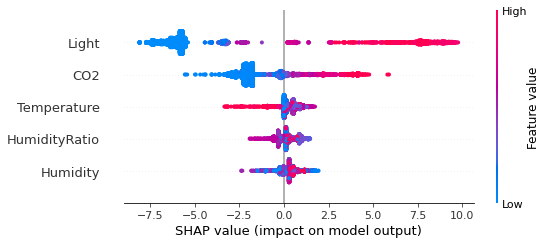

In [14]:
explainer = shap.TreeExplainer(xgbc)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

Из диаграммы summary_plot видно, что


1. Чем выше уровень освещенности, тем выше вероятность присутствия человека в помещении. Это логично, поскольку люди редко присутствуют в темных помещениях (за исключением спальных комнат).
2. Чем выше уровень углекислого газа в воздухе, тем выше вероятность нахождения человека в помещении.
3. Есть тенденция, что чем выше температура, тем ниже вероятность нахождения человека в помещении, однако, эта тенденция не столь однозначна, как в первых двух случаях. Это, скорее всего, говорит нам о том, что помещение оснащено кондиционером воздуха.
4. Не похоже, что по отностительной и абсолютной влажностям можно уверенно судить о наличии человека в помещении.

In [15]:
idx = 176
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_train.iloc[idx,:])

In [16]:
print(f'index = {idx}\nlabel = {y_train.iloc[idx]}')

index = 176
label = 0


Низкие уровни освещенности и СО2 говорят нам об отсутствии человека, что так же подтверждается меткой класса.

In [17]:
idx = 5853
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_train.iloc[idx,:])

In [18]:
print(f'index = {idx}\nlabel = {y_train.iloc[idx]}')

index = 5853
label = 0


Выводы те же, что и в предыдущем примере.

In [19]:
idx = 791
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_train.iloc[idx,:])

In [20]:
print(f'index = {idx}\nlabel = {y_train.iloc[idx]}')

index = 791
label = 1


Все показатели, говорят о наличии человека в помещении.

In [21]:
idx = 443
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_train.iloc[idx,:])

In [22]:
print(f'index = {idx}\nlabel = {y_train.iloc[idx]}')

index = 443
label = 0


Темное помещения с низким уровнем СО2, говорит об остутствии человека.

In [23]:
idx = 6053
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_train.iloc[idx,:])

In [24]:
print(f'index = {idx}\nlabel = {y_train.iloc[idx]}')

index = 6053
label = 1


Высокие уровни освещенности, СО2, а также повышенная влажность говорят о наличии человека.